<a href="https://colab.research.google.com/github/mvenouziou/Project_Style_Transfer/blob/master/Audio_Visual_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Audio + Image Style Transfer Model

This app takes a 'content' image and adapts it with texture elements from an audio clip or second image. 

Experimental Feature: use an audio file in place of a style image

- Try my web app implementation at www.communicatemission.com/ml-projects#style_transfer. (audio style not yet implemented)


---
Credits / Attributions:

Using Audio as Style source:

- I have not seen this done before. 
- The basic concept of representing audio as an image in order to apply visual network tools was learned by me from reading *Deep Learning for Coders with fastai & Pytorch* by Howard and Gugger (2020).

Image Content & Style Models:

- This has been been coded heavily relying on techniques from DeepLearning.ai specialization on Coursera (www.coursera.org/learn/nlp-sequence-models) and the Tensorflow style transfer documentation (www.tensorflow.org/tutorials/generative/style_transfer), which are in turn based on a paper by Gatys, Ecker and Bethge (https://arxiv.org/abs/1508.06576). The web app is built on the Anvil platform.*

- Pretrained image models used are loaded from the tf.keras.applications model. This model currently ustilizes VGG19 (citation: *Very Deep Convolutional Networks for Large-Scale Image Recognition (ICLR 2015))*

Images from photographers posted on Unsplash.com :

- <a href="https://unsplash.com/@abm25?utm_source=unsplash&amp;utm_medium=referral&amp;utm_content=creditCopyText">*Aida Batres*</a>
- <a href="https://unsplash.com/@bmowinkel?utm_source=unsplash&amp;utm_medium=referral&amp;utm_content=creditCopyText">*Brandon Mowinkel*</a>
- <a href="https://unsplash.com/@autumnstudio?utm_source=unsplash&amp;utm_medium=referral&amp;utm_content=creditCopyText">*Autumn Studio*</a>
- <a href="https://unsplash.com/@joshhild?utm_source=unsplash&amp;utm_medium=referral&amp;utm_content=creditCopyText">*Josh Hild*</a>
- <a href="https://unsplash.com/@pawel_czerwinski?utm_source=unsplash&amp;utm_medium=referral&amp;utm_content=creditCopyText">*Paweł Czerwiński*</a>
- <a href="https://unsplash.com/@lucassankey?utm_source=unsplash&amp;utm_medium=referral&amp;utm_content=creditCopyText">*Lucas Sankey*</a>
- <a href="https://unsplash.com/@ivanana?utm_source=unsplash&amp;utm_medium=referral&amp;utm_content=creditCopyText">*Ivana La*</a>
- <a href="https://unsplash.com/@charlesdeluvio?utm_source=unsplash&amp;utm_medium=referral&amp;utm_content=creditCopyText">*Charles Deluvio*</a>

In [59]:
#### REQUIRED IMPORTS ####

# ML design
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
import tensorflow_probability as tfp

# data handling
import numpy as np
from PIL import Image
!pip install librosa -q  # audio processing
import librosa

# computations
from scipy.special import expit, logit

# visualization
import matplotlib.pyplot as plt 
%matplotlib inline
import IPython.display as display

# audio
from IPython.display import Audio

# file management
import pickle

##### GLOBAL VARIABLES
File directories and hyperparameters

In [60]:
# GLOBAL VARIABLES - Parameters
PIXELS = 224
SIZE = (PIXELS, PIXELS)
CONTENT_WEIGHT = 10000
STYLE_WEIGHT = 1
LAYERS_WEIGHTS = {#2: 0.2,  # choose style layers & weighting to use
                  #5: 0.2,
                  10: 0.2,
                  12: 0.15,
                  #15: 0.2,
                  #20: 0.2,
                  }

In [61]:
# GLOBAL VARIABLES - File Structure

# 3rd Party Integrations (enabled / disabled)
USE_ANVIL = False
USE_GOOGLE_DRIVE = False

# File Directory Structure
# images datasets (Github)
IMAGES_DIR = \
    'https://raw.githubusercontent.com/mvenouziou/Style_Transfer/master/'

AUDIO_DIR = '/content/'

# saved models (Google Drive)
GDRIVE_DIR = '/content/gdrive/'
FILEPATH = GDRIVE_DIR + 'MyDrive/Colab_Notebooks/models/style_transfer/'
CHECKPOINT_DIR = FILEPATH + 'checkpoints/'
CACHE_DIR = FILEPATH + 'cache/'
GENERATED_IMAGES_DIR = FILEPATH + 'generated_images/'

# mount google drive:
if USE_GOOGLE_DRIVE:
    from google.colab import drive
    drive.mount(GDRIVE_DIR)

# connect to Anvil web app server
if USE_ANVIL:
    # Anvil Web App server
    !pip install anvil-uplink
    import anvil.server
    anvil.server.connect("TGQHRRT52QMUFNNQBSVS5MVT-FXYOFTHT5SD2KYNR")
    import anvil.media

In [62]:
# GLOBAL VARIABLES - Images

# set default images
DEFAULT_CONTENT_IMAGE_NAME = 'protest'
DEFAULT_STYLE_IMAGE_NAME = 'flowers'
DEFAULT_TRANSFER_MODEL_NAME = 'vgg'

# available images (free license images sourced from unsplash.com)
IMAGE_OPTIONS = \
    {'dog':'ivana-la-Dhlwt-VOmeM-unsplash.jpg',
     'dog2':'charles-deluvio-Mv9hjnEUHR4-unsplash.jpg',
     'protest': 'josh-hild-RD0BXCGemEY-unsplash.jpg',
     'statue_of_liberty': 'brandon-mowinkel-UGi_Ng56FRI-unsplash.jpg',
     'two_color_straight': 'autumn-studio-PaM7SD5wM6g-unsplash.jpg',
     'flowers': 'aida-batres-_QxzSVWesm0-unsplash.jpg',
     'colors_wild': 'pawel-czerwinski-g2Zf3hJyYAc-unsplash.jpg',
     'flag': 'lucas-sankey-gdQ_az6CSPo-unsplash.jpg',
     }

AUDIO_OPTIONS = {#'song1': 'song1.wav',
                 'song1': "01 - Beck - Devil's Haircut.m4a",
                 'song2': "05 - Beck - Derelict.m4a"}

# audio transforms
# Fourier
fourier = {'trans_func': librosa.stft,  # Short-time Fourier Transform (STFT)
           'inv_trans_func': librosa.istft,  # Short-time Fourier Transform (STFT)
           'hop_length': None,
           }
# constant-Q
constant_Q = {'trans_func': librosa.cqt,
              'inv_trans_func': librosa.icqt,
              'hop_length': 1 * (2**6),
              }
tempogram = {'trans_func': librosa.feature.tempogram,
              'inv_trans_func': None,
              'hop_length': 512,
              }
AUDIO_TRANSFORM_PARAMS = {'Fourier': fourier,
                          'constant_Q': constant_Q,
                          'tempgram': tempogram}

# available transfer learning base models
TRANSFER_MODEL_OPTIONS = \
    {'vgg': tf.keras.applications.VGG19, # ImageNet VGG Very Deep 19
    #'mobile_net': tf.keras.applications.MobileNetV3Small,
     }

#### Load pretrained VGG net as base model for transfer learning

In [63]:
# load pre-trained model for extracting style layers
def load_base_model(transfer_model_name, 
                    transfer_model_options=TRANSFER_MODEL_OPTIONS):
    
    """
    ##### parameters set for using VGG
    To do: add more model options
    """
    # select model
    model = transfer_model_options[transfer_model_name]

    # load model
    source_model = model(include_top=False, 
                         weights='imagenet', 
                         input_tensor=None, 
                         input_shape=None, 
                         pooling=None, 
                         #classes=1000, 
                         classifier_activation='softmax')
   
    # lock model for transfer learning
    source_model.trainable = False  

    return source_model

Get source contant / style files

In [64]:
def load_image_from_URL(image_name, 
                        images_directory=IMAGES_DIR,
                        image_options=IMAGE_OPTIONS,
                        cache_dir=CACHE_DIR):
    
    # choose from saved options
    filename = image_options[image_name]
    image_path = tf.keras.utils.get_file(filename, 
                                    origin=images_directory + filename,
                                    cache_subdir=cache_dir)

    return image_path


def load_audio_from_URL(audio_name, 
                       audio_directory=AUDIO_DIR,
                       audio_options=AUDIO_OPTIONS):
    
    # choose from saved options
    filename = audio_options[audio_name]
    audio_clip = librosa.load(path = audio_directory + filename, 
                              sr=11025, mono=True, offset=0.0, 
                              duration=10, #
                              res_type='kaiser_best')
    audio_clip = audio_clip[0]
    print('audio_clip:', audio_clip.shape)


    return audio_clip

#### Image Preprocessing

In [65]:
# load and prepare images for model
def prepare_images(image_path, size):
    """ converts images to tensors and standardizes for model """

    # load images as PIL and resize
    image = tf.keras.preprocessing.image.load_img(image_path, target_size=size)

    # convert to array and standardize
    image = tf.keras.preprocessing.image.img_to_array(image)
    image = image / 255.

    # add batch dimension and convert to tensor: (1, height, width, channels)
    image = tf.expand_dims(image, axis=0)

    # record original image (relative) dimensions 
    # (to produce undistorted final image)
    orig_image = tf.keras.preprocessing.image.load_img(image_path, target_size=None)
    orig_image = tf.keras.preprocessing.image.img_to_array(orig_image)
    orig_shape = orig_image.shape[:2]

    return image, orig_shape


def initialize_generated_image(input_image, noise_rate, size=SIZE):
    """ creates noisy version of content image """

    # define random noise
    noise = tf.random.uniform(shape=input_image.shape, minval=-20, maxval=20)
    
    # update image
    image = noise * noise_rate + input_image * (1 - noise_rate)

    # convert to tensor
    image_tensor = tf.convert_to_tensor(image)
    
    return image_tensor

Audio Preprocessing

In [66]:
def audio_to_image(audio_clip, size=SIZE, show_image=True, transform='tempgram', 
                   transform_params=AUDIO_TRANSFORM_PARAMS):
    """ converts an audio clip to a spectrogram-type image (tensor)."""

    # get transform paramaters
    params = transform_params[transform]
    trans_func = params['trans_func']
    hop_length = params['hop_length']

    # apply transform to audio clip
    transformed = trans_func(y=audio_clip,
                             hop_length=hop_length )  

    print('transformed:', tf.shape(transformed))
    if transform != 'tempgram':
        transformed = np.log(transformed)   # log transform to accentuate features

    # convert Real and Imaginary components into RGB representation
    rgb = np.dstack((transformed.real, transformed.imag, 
                     .5 * (transformed.real + transformed.imag)))

    # map values into interval [0, 1]
    # using scipy.special.expit (sigmoid function)
    rgb = expit(rgb)
    
    # add batch dimension: (1, r, g, b)
    image_tensor = tf.expand_dims(rgb, axis=0)

    # resize for pre-trained model 
    orig_size = image_tensor.shape[1:3]
    image_tensor = tf.image.resize(image_tensor, 
                                   size=size,
                                   method='bilinear')

    if show_image:
        im = image_tensor#tf.squeeze(image_tensor)
        convert_tensor_to_image(im, view=True)

    return image_tensor, orig_size, transform


def tensor_to_audio(image_tensor, orig_size, transform='Fourier', 
                    transform_params=AUDIO_TRANSFORM_PARAMS):
    """ 'almost' inverse function to 'audio_to_image()'. 
    (Lossy due to compression) 
    Returns: audio (as numpy array), audio file player"""

    # resize
    image_tensor = tf.image.resize(image_tensor, 
                                   size=orig_size,
                                   method='bilinear')

    # drop batch dim and convert to numpy
    rgb = tf.squeeze(image_tensor).numpy()

    # expand from interval [0, 1] to full spectrum
    # using scipy.special.logit (inverse sigmoid function)
    rgb = logit(rgb)

    # convert to complex number representation
    rgb = np.split(rgb, indices_or_sections=3, axis=2)
    rgb = rgb[0] + 1j * rgb[1]
    rgb = np.squeeze(rgb)

    # undo log transform and reverse STFT representation
    rgb = np.exp(rgb)

    params = transform_params[transform]
    trans_func = params['inv_trans_func']
    hop_length = params['hop_length']
    audio_clip = trans_func(rgb, hop_length=hop_length)

    # using IPython.display.Audio
    file_player = Audio(np.sin(audio_clip), rate=22050, autoplay=True)
    
    return audio_clip, file_player

#### Custom Cost Functions
Measures the differences between generated image and 1) content image and 2) style layers from style image.

In [67]:
### Cost Functions - Image Content
# this cost component helps generated image resemble the content image
# it is only applied to the final generated image
def content_cost(image_activations, generated_activations, content_layer):

    # load content tensors
    image_activ = image_activations[content_layer]
    generated_activ = generated_activations[content_layer]

    # define scale factor for this cost component
    height = image_activ.shape[-3]
    width = image_activ.shape[-2]
    num_channels = image_activ.shape[-1]
    scale_factor = 1 / (4 * height * width * num_channels)

    # compute cost as distance between source image and generated image
    distance = image_activ - generated_activ
    cost = scale_factor * tf.norm(tensor=distance, ord='euclidean')

    return cost

In [68]:
### Cost Functions - Gradient Content (represents image style)
# this cost component helps generated image resemble the style image's texture
# it is applied to interior image layer activation(s)

# measures the difference in gradients between image and generated images
def gram_matrix(image):
    """
    Computes Gram Matrix
    Parameter: tensors of shape (px_width, px_height, channels)
    """

    num_channels = image.shape[-1]
    image = tf.reshape(image, [-1, num_channels])
    gram = tf.linalg.matmul(image, image, transpose_a=True, transpose_b=False)

    return gram


# adds up gram_matrix across chosen layers
def style_cost(style_activations, generated_activations, weights):

    # initialize cost
    cost = 0

    for layer in weights.keys():

        # get content data
        style_activ = style_activations[layer]
        generated_activ = generated_activations[layer]
        weight = weights[layer]

        # compute scale factor (scale factor used in deeplearning.ai specialization)
        height = style_activ.shape[-3]
        width = style_activ.shape[-2]
        num_channels = style_activ.shape[-1]
        scale_factor = 1 / (4 * (height**2) * (width**2) * (num_channels**2))

       # compute distance between style and generated gradients
        gram_style = gram_matrix(style_activ)
        gram_generated = gram_matrix(generated_activ)
        distance = gram_style - gram_generated

       # compute cost
        cost += weight * scale_factor * tf.norm(distance, ord=2)**2

    return cost

#### Forward Pass Definition

In [69]:
def learn_activations(input_tensor, orig_model, layer_nums):
    """
    Conducts forward pass of given model and stores activations
    indicated by layers list.
    """

    # initialize activations container
    activations_computed = dict()

    # forward passes through selected layers
    x = input_tensor

    for k in range(len(layer_nums)):
        if k==0:
            start_layer = 0
        else:
            start_layer = layer_nums[k-1] + 1
            
        end_layer = layer_nums[k]
        
        # travel through model to next desired activation layer
        for layer_number in range(start_layer, end_layer+1):
            x = orig_model.layers[layer_number](x)
        
        # record activation
        activations_computed[end_layer] = x

    # ensure final layer output is included
    final_layer_num = len(orig_model.layers) - 1
    if final_layer_num not in activations_computed:

        # travel through model to next desired activation layer
        start_layer = np.max(layer_nums) + 1
        end_layer = final_layer_num
        for layer_number in range(start_layer, end_layer+1):
            x = orig_model.layers[layer_number](x)
        
        # record activation
        activations_computed[end_layer] = x

    return activations_computed

In [82]:
def train_generated_image(init_generated_image, image_activations, 
                          style_activations, cnn_model, 
                          content_weight, style_weight, 
                          num_iterations, learning_rate, 
                          layers_dict=LAYERS_WEIGHTS, 
                          checkpoint_dir=CHECKPOINT_DIR,
                          generated_images_dir=GENERATED_IMAGES_DIR):

    # show initial (noisy) image
    def view_tensor_as_image(learned_image_tensor, show=True):
        
        # rescale image to take on RGB values between 0 and 255
        #learned_image = tf.convert_to_tensor(learned_image_tensor * 255)
        learned_image = learned_image_tensor * 255
        
        # remove dummy dimension (representing batch_size component)
        learned_image = tf.squeeze(learned_image)

        # show image
        if show:
            display.clear_output(wait=True)
            display.display(convert_tensor_to_image(learned_image, False))
                
        return learned_image

    print('Original image:\n')
    view_tensor_as_image(init_generated_image, show=True)

    # initialize containers
    computed_images_dict = dict()

    # get parameters
    layers = list(layers_dict.keys())
    content_layer = len(cnn_model.layers) - 1

    # initialize trainable variables (generated image)
    learned_im = tf.Variable(init_generated_image)

    # set optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, 
                                         epsilon=1e-1, amsgrad=True,)
    
    # (loss function defined within training loop)

    # training loop
    for iteration in range(num_iterations):
        
        # enforce image as trainable
        # (computations below may convert to 'eager tensor')
        learned_im = tf.Variable(learned_im)

        # forward pass
        # set gradient tracking
        with tf.GradientTape() as tape:

            # reset loss function with new variable values
            def loss_function(variable=learned_im):

                # get activations
                generated_activations = \
                    learn_activations(variable, cnn_model, layers)

                # compute loss
                loss = content_weight * content_cost(image_activations, 
                                                     generated_activations, 
                                                     content_layer) + \
                        style_weight * style_cost(style_activations, 
                                                  generated_activations, 
                                                  layers_dict)             
                return loss

        # backward pass
        optimizer.minimize(loss=loss_function, var_list=[learned_im])

        ## (maintain image values between 0 and 1)
        learned_im = tfp.math.clip_by_value_preserve_gradient(
                                      learned_im, 
                                      clip_value_min=0.0, 
                                      clip_value_max=1.0
                                      )

        # save progress and give status updates
        # report results / save checkpoints
        if iteration % 20 == 0:
            
            # report status
            print("iteration:", iteration)
            print("loss:", loss_function().numpy())

            # show generated image
            learned_image = view_tensor_as_image(learned_im, show=True)

            # save generated image in checkpoint            
            if USE_GOOGLE_DRIVE:
                
                save_filename = checkpoint_dir + 'learned_im_tensor_' + \
                                '_iter_' + str(iteration) + '.pickle'

                with open(save_filename, 'wb') as handle:
                    pickle.dump(learned_image, handle, 
                                protocol=pickle.HIGHEST_PROTOCOL)
    
    # training ends                
    # show results
    print("Final loss:", loss_function().numpy())

    # convert back to viewable image (tensor)
    learned_image = view_tensor_as_image(learned_im)

    # save result
    if USE_GOOGLE_DRIVE:
        save_filename = generated_images_dir + 'learned_im.jpg'
        tf.keras.preprocessing.image.save_img(save_filename, 
                                              learned_image)

    return learned_image


In [71]:
def style_transfer(saved_variables, content_name, style_name, 
                   transfer_model_name, learning_rate,num_iterations,
                   checkpoint_dir=CHECKPOINT_DIR, content_weight=CONTENT_WEIGHT,
                   style_weight=STYLE_WEIGHT):

    print('Note: Generated image may take time to converge)\n' +
       'Use of GPU or low number of iterations highly recommended')

    """
    note: 
    saved_variables = {'activations': activations_dict,
                       'layers_dict': layers_dict,
                       'init_generated_image': init_generated_image,
                       'source_tensors': source_tensors_dict,
                       'transfer_model': transfer_model,
                       }
    """


    # get transfer base model
    transfer_model = saved_variables['transfer_model'][transfer_model_name]
    
    # get prepared images
    image_tensor = saved_variables['source_tensors'][content_name]
    style_tensor = saved_variables['source_tensors'][style_name]
    init_generated_image = \
        saved_variables['init_generated_image'][content_name]
    
    # get CNN layer numbers for transfer
    layers_dict = saved_variables['layers_dict']

    # get activations based on pretrained transfer model
    image_activations = saved_variables['activations'][content_name]
    style_activations = saved_variables['activations'][style_name]

    # generate new image / train model
    learned_image = \
        train_generated_image(init_generated_image=init_generated_image, 
                              image_activations=image_activations, 
                              style_activations=style_activations, 
                              cnn_model=transfer_model, 
                              layers_dict=layers_dict, 
                              content_weight=content_weight, 
                              style_weight=style_weight, 
                              num_iterations=num_iterations,
                              learning_rate=learning_rate,
                              checkpoint_dir=checkpoint_dir
                              )

    return learned_image

#### Image viewer

In [72]:
# Helper filer: converts image from tensor format to viewable format
def convert_tensor_to_image(image_tensor, output_shape=(300, 100), view=True):
    
    image = tf.image.resize(images=image_tensor, 
                            size=[200,200])

    # convert tensor to image
    im_array = image.numpy()
    image = tf.keras.preprocessing.image.array_to_img(
                    im_array, data_format=None, scale=True, dtype=None)

    # display image
    if view is True:
        plt.imshow(image)

    return image

Preload prepared image / models



In [73]:
# Preload prepared image / models

def preload_variables(transfer_model_name=DEFAULT_TRANSFER_MODEL_NAME,
                      transfer_model_options=TRANSFER_MODEL_OPTIONS,
                      image_options=IMAGE_OPTIONS,
                      audio_options=AUDIO_OPTIONS,
                      layers_dict=LAYERS_WEIGHTS,
                      noise_rate=.01,
                      size=SIZE):

    # initialize containers
    transfer_models_dict = {}
    source_tensors_dict = {}
    init_generated_image_dict = {}
    activations_dict = {}
    output_shapes_dict = {}

    # prepare transfer model
    for model_name in transfer_model_options:
        transfer_models_dict[model_name] \
            = load_base_model(model_name, transfer_model_options)

    # get layer numbers for activation computations
    layers = list(layers_dict.keys())  

    # process each image
    for name in {**image_options , **audio_options}:  # merged dicts

        # load images
        if name in image_options:
            print(f'loading image: {name}')

            # load and preprocess as tensor
            image_path = load_image_from_URL(name)
            source_tensor, output_shape = prepare_images(image_path=image_path, 
                                                        size=size)

            # record shape
            output_shapes_dict[name] = output_shape

        # load audio
        if name in audio_options:
            print(f'loading audio: {name}')

            # load and preprocess as tensor
            audio_clip = load_audio_from_URL(name)
            source_tensor, orig_size, transform = audio_to_image(audio_clip, show_image=False)
        
        # initialize corresponding generated image
        init_generated_image = \
            initialize_generated_image(source_tensor, noise_rate)

        # compute activations
        for model_name in transfer_model_options:
            model = transfer_models_dict[model_name]
            activations = learn_activations(source_tensor, model, layers)
        
        # save in dict
        source_tensors_dict[name] = source_tensor
        init_generated_image_dict[name] = init_generated_image
        activations_dict[name] = activations

    # organize outputs
    out = {'activations': activations_dict,
           'layers_dict': layers_dict,
           'init_generated_image': init_generated_image_dict,
           'source_tensors': source_tensors_dict,
           'transfer_model': transfer_models_dict,
           'output_shape': output_shapes_dict,
           }

    return out

Pre-load Images, Model and Activations

In [74]:
SAVED_VARIABLES_DICT = preload_variables(
                            transfer_model_name=DEFAULT_TRANSFER_MODEL_NAME,
                            transfer_model_options=TRANSFER_MODEL_OPTIONS,
                            image_options=IMAGE_OPTIONS,
                            audio_options=AUDIO_OPTIONS,
                            noise_rate=.01,
                            size=SIZE)

loading image: dog
loading image: dog2
loading image: protest
loading image: statue_of_liberty
loading image: two_color_straight
loading image: flowers
loading image: colors_wild
loading image: flag
loading audio: song1


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


audio_clip: (110250,)
transformed: tf.Tensor([384 216], shape=(2,), dtype=int32)
loading audio: song2


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


audio_clip: (110250,)
transformed: tf.Tensor([384 216], shape=(2,), dtype=int32)


# New Section

Final Function for Generating Images

In [77]:
#@anvil.server.callable
def generate_image(orig_image=DEFAULT_CONTENT_IMAGE_NAME, 
                   style_image=DEFAULT_STYLE_IMAGE_NAME,
                   transfer_model_name=DEFAULT_TRANSFER_MODEL_NAME,
                   learning_rate=.20,
                   num_iterations=3):   

    learned_image = \
        style_transfer(saved_variables=SAVED_VARIABLES_DICT,
                       content_name=orig_image, 
                       style_name=style_image, 
                       transfer_model_name=transfer_model_name,
                       learning_rate=learning_rate,
                       num_iterations=num_iterations)

    save_filename = 'temp.jpg'    
    tf.keras.preprocessing.image.save_img(save_filename, learned_image)

    if USE_ANVIL:
        im_file = anvil.media.from_file("temp.jpg")
        
    else:
        im_file = convert_tensor_to_image(image_tensor=learned_image, 
                                          view=True)
    
    return im_file

if USE_ANVIL:
    anvil.server.wait_forever()

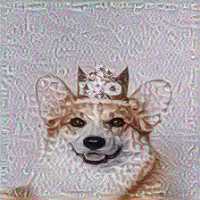

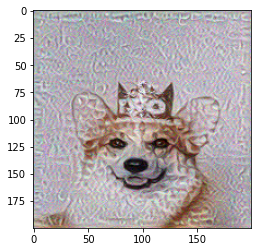

In [83]:
# Run program
orig_image = 'dog'
style_image = 'song2'

temp_image = generate_image(orig_image, 
                            style_image,
                            learning_rate=.5,
                            num_iterations=3)

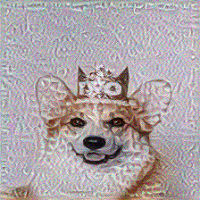

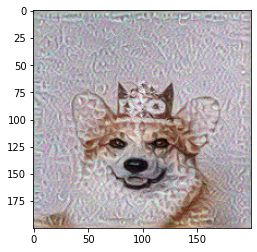

In [79]:
# Run program
# EXPERIMENTAL / IN PROGRESS: Using audio as style source
orig_image = 'dog'
style_image = 'song1'

temp_image = generate_image(orig_image, 
                            style_image,
                            learning_rate=.5,
                            num_iterations=3)